Use of Convolutional Neural Network to determine the breed of a dog in an image.

Getting the data to train the convolutional neural network from Kaggle. 

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yawbrown","key":"f2c3e866145d780108a433c9a523b9c6"}'}

Setting up the Kaggle

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json



Creating files and downloading the data to train the CNN

In [5]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [6]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           3509          7  0.1764706        


In [7]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 682M/691M [00:09<00:00, 93.2MB/s]
100% 691M/691M [00:09<00:00, 72.7MB/s]
/content


In [8]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset



Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [9]:
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Importing Libraries needed for the CNN

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [11]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)

(10222, 2)


In [12]:
pd.set_option('display.max_rows', None)

In [13]:
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [14]:
breed_counts

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
leonberg                          106
cairn                             106
beagle                            105
japanese_spaniel                  105
australian_terrier                102
blenheim_spaniel                  102
miniature_pinscher                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
norwegian_elkhound                 95
whippet                            95
siberian_husky                     95
pug         

In [15]:
narrowed_classes=['scottish_deerhound','maltese_dog','bernese_mountain_dog']


In [16]:
#Due to lack of processing power and with the computer I was using I narrowed down to the 3 most common breeds of dogs.
labels = labels_all[(labels_all['breed'].isin(narrowed_classes))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [17]:
import keras.utils as image

In [18]:
# Creating numpy matrix with zeros as the placeholder for the inputs
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding for the output since this is a classifier.
Y_data = label_binarize(labels['breed'], classes = narrowed_classes)

# Reading and converting image to numpy array and now it is an array we can afford to normalize the dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:02<00:00, 156.03it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(narrowed_classes), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [20]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.05)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.1)

In [21]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 59s 15s/step - loss: 4.8952 - accuracy: 0.3148 - val_loss: 4.8700 - val_accuracy: 0.3529
Epoch 2/100
3/3 [==============================] - 50s 15s/step - loss: 4.8539 - accuracy: 0.3574 - val_loss: 4.8321 - val_accuracy: 0.3235
Epoch 3/100
3/3 [==============================] - 50s 15s/step - loss: 4.8192 - accuracy: 0.3607 - val_loss: 4.7961 - val_accuracy: 0.3235
Epoch 4/100
3/3 [==============================] - 49s 15s/step - loss: 4.7817 - accuracy: 0.3607 - val_loss: 4.7631 - val_accuracy: 0.3235
Epoch 5/100
3/3 [==============================] - 50s 15s/step - loss: 4.7461 - accuracy: 0.3574 - val_loss: 4.7293 - val_accuracy: 0.3235
Epoch 6/100
3/3 [==============================] - 51s 15s/step - loss: 4.7107 - accuracy: 0.3574 - val_loss: 4.6926 - val_accuracy: 0.3235
Epoch 7/100
3/3 [==============================] - 50s 15s/step - loss: 4.6741 - accuracy: 0.3607 - val_loss: 4.6564 - val_accuracy: 0.3529
Epoch 8/100
3/3 [===

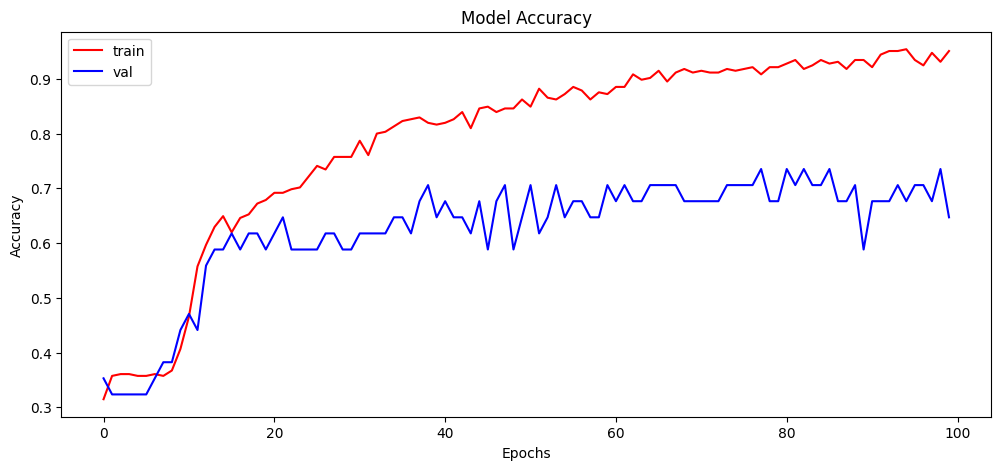

In [22]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [23]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

1/1 [==============================] - 1s 653ms/step - loss: 2.7597 - accuracy: 0.8333
Accuracy over the test set: 
  83.33 %


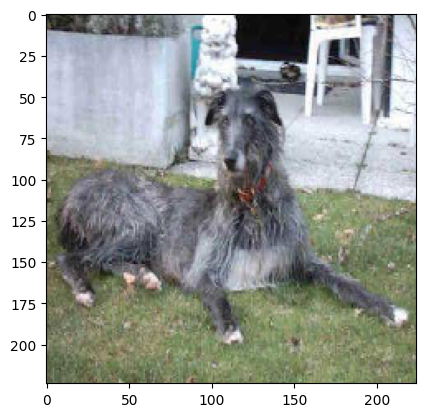

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [24]:
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [26]:
model.save("dog_breed1.h5")